<a href="https://colab.research.google.com/github/tylerlum/deep_learning_monte_carlo_dropout/blob/main/mc_dropout_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Dropout on MNIST

Reference:
https://www.depends-on-the-definition.com/model-uncertainty-in-deep-learning-with-monte-carlo-dropout/#2-selection-by-variance

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

## Setup train/test datasets

In [2]:
batch_size = 128
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Setup regular model and MC model

In [7]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [8]:
model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")

## Train and evaluate regular model

In [9]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 7s 15ms/step - loss: 2.2765 - accuracy: 0.1672 - val_loss: 2.2385 - val_accuracy: 0.3965
Epoch 2/100
469/469 [==============================] - 7s 14ms/step - loss: 2.2177 - accuracy: 0.2900 - val_loss: 2.1655 - val_accuracy: 0.6054
Epoch 3/100
469/469 [==============================] - 7s 14ms/step - loss: 2.1407 - accuracy: 0.3948 - val_loss: 2.0679 - val_accuracy: 0.6840
Epoch 4/100
469/469 [==============================] - 7s 14ms/step - loss: 2.0377 - accuracy: 0.4729 - val_loss: 1.9381 - val_accuracy: 0.7072
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 1.9056 - accuracy: 0.5264 - val_loss: 1.7725 - val_accuracy: 0.7198
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 1.7467 - accuracy: 0.5624 - val_loss: 1.5785 - val_accuracy: 0.7316
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 1.5784 - accuracy: 0.5937 - val_loss: 1.3776 - val_accuracy:

In [10]:
def plot_train_validation(history, plot_type):
  plt.plot(h.history[plot_type])
  plt.plot(h.history[f'val_{plot_type}'])
  plt.title(f'model {plot_type}')
  plt.ylabel(plot_type)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

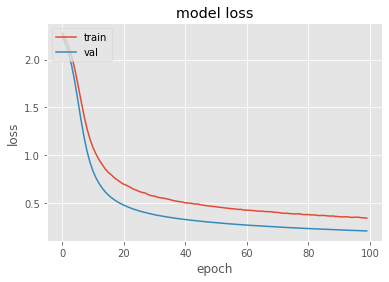

In [11]:
plot_train_validation(h, "loss")

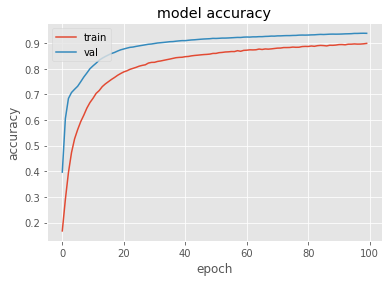

In [12]:
plot_train_validation(h, "accuracy")

In [13]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20478086173534393
Test accuracy: 0.9380999803543091


## Train and evaluate MC model

In [14]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 7s 15ms/step - loss: 2.2819 - accuracy: 0.1419 - val_loss: 2.2458 - val_accuracy: 0.2070
Epoch 2/100
469/469 [==============================] - 7s 14ms/step - loss: 2.2073 - accuracy: 0.2715 - val_loss: 2.1630 - val_accuracy: 0.3373
Epoch 3/100
469/469 [==============================] - 7s 14ms/step - loss: 2.1127 - accuracy: 0.3879 - val_loss: 2.0518 - val_accuracy: 0.4321
Epoch 4/100
469/469 [==============================] - 7s 14ms/step - loss: 1.9875 - accuracy: 0.4670 - val_loss: 1.9049 - val_accuracy: 0.5140
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 1.8327 - accuracy: 0.5315 - val_loss: 1.7399 - val_accuracy: 0.5629
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 1.6559 - accuracy: 0.5792 - val_loss: 1.5443 - val_accuracy: 0.6156
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 1.4709 - accuracy: 0.6191 - val_loss: 1.3668 - val_accuracy:

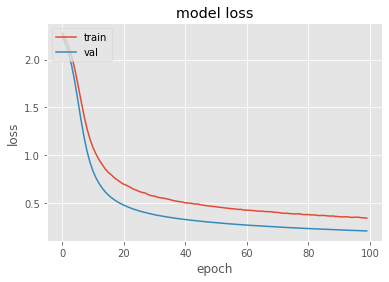

In [15]:
plot_train_validation(h_mc, "loss")

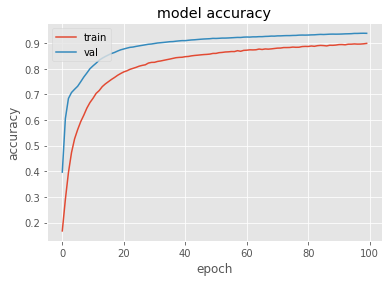

In [16]:
plot_train_validation(h_mc, "accuracy")

## Calculate MC Dropout Predictions

In [17]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


In [18]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 91.2%


In [19]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 94.5%


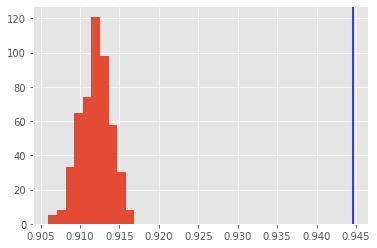

In [20]:
plt.hist(accs)
plt.axvline(x=ensemble_acc, color="b")

## Test MC Dropout results

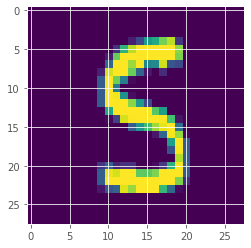

In [21]:
idx = 240
plt.imshow(x_test[idx][:,:,0])

In [22]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 5
true label: 5

class: 0; proba: 0.1%; var: 0.26% 
class: 1; proba: 0.0%; var: 0.29% 
class: 2; proba: 0.2%; var: 0.93% 
class: 3; proba: 3.2%; var: 7.46% 
class: 4; proba: 0.0%; var: 0.14% 
class: 5; proba: 90.0%; var: 15.24% 
class: 6; proba: 0.3%; var: 1.10% 
class: 7; proba: 0.0%; var: 0.02% 
class: 8; proba: 5.9%; var: 12.32% 
class: 9; proba: 0.3%; var: 1.12% 


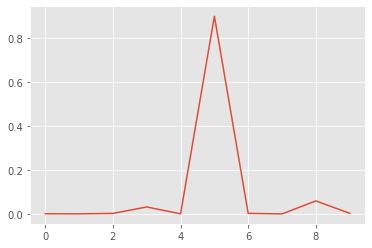

In [23]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

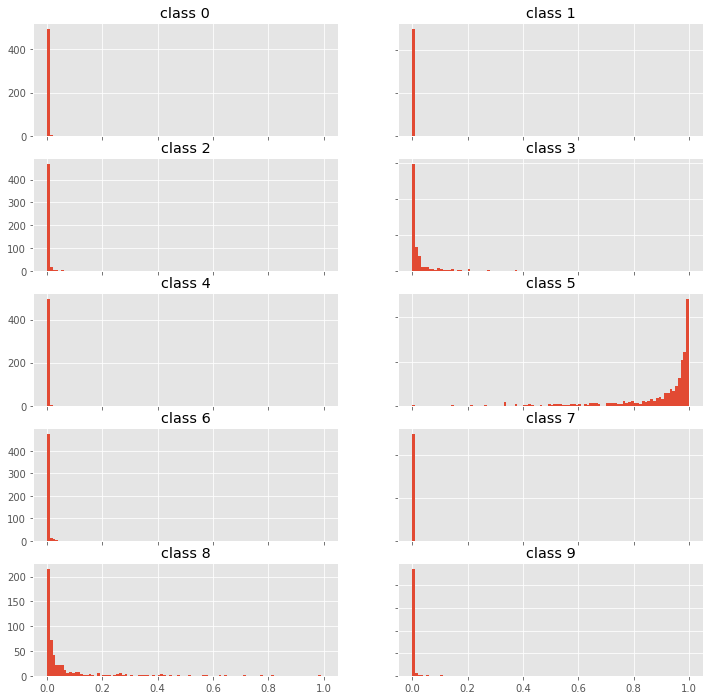

In [24]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## View images with lowest probability

In [25]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [26]:
(np.array(max_means)).argsort()[:10]

array([193,  33, 195, 406, 300, 495, 151, 403, 149, 325])

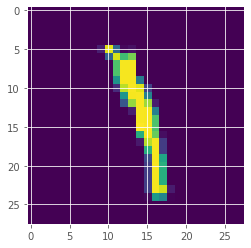

In [27]:
plt.imshow(x_test[96][:,:,0])

## View images with highest variance

In [28]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

In [29]:
(-np.array(max_vars)).argsort()[:10]

array([412, 233, 449, 362, 139, 359, 126, 349,  63, 352])

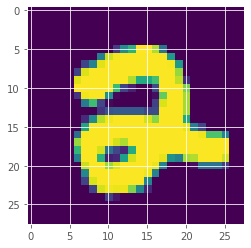

In [30]:
plt.imshow(x_test[222][:,:,0])

## Test MC dropout on random image

In [31]:
random_img = np.random.random(input_shape)

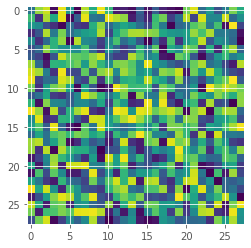

In [32]:
plt.imshow(random_img[:,:,0]);

In [33]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


In [34]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 3

class: 0; proba: 2.2%; var: 3.52% 
class: 1; proba: 1.1%; var: 1.66% 
class: 2; proba: 7.5%; var: 8.69% 
class: 3; proba: 59.0%; var: 23.47% 
class: 4; proba: 0.8%; var: 1.56% 
class: 5; proba: 14.0%; var: 11.80% 
class: 6; proba: 4.2%; var: 6.96% 
class: 7; proba: 2.1%; var: 4.63% 
class: 8; proba: 9.1%; var: 10.27% 
class: 9; proba: 0.1%; var: 0.25% 


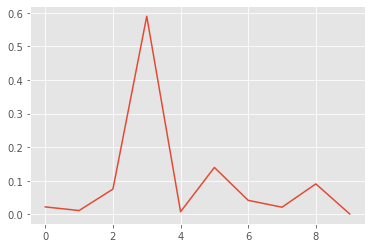

In [35]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

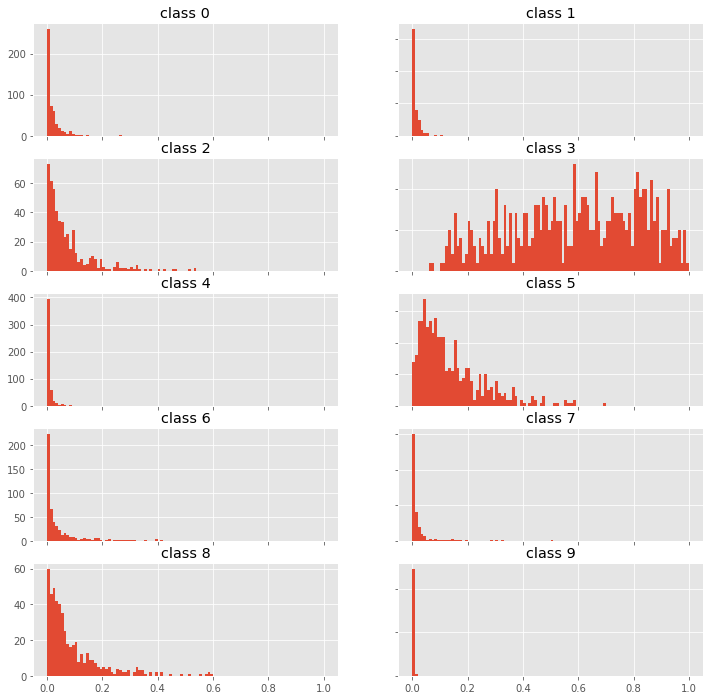

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

## Convert trained regular model into a MC model

In [49]:
layers = [l for l in model.layers]
x = layers[0].output
for i in range(1, len(layers)):
    # Replace dropout layers with MC dropout layers
    if isinstance(layers[i], Dropout):
        x = Dropout(0.2)(x, training=True)
    else:
        x = layers[i](x)
        
mc_model2 = Model(inputs=layers[0].input, outputs=x)
mc_model2.set_weights(model.get_weights())
mc_model2.predict(np.expand_dims(x_test[222], axis=0), batch_size=1).argmax()

2

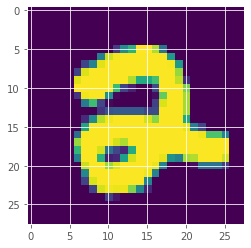

In [50]:
idx = 222
plt.imshow(x_test[idx][:,:,0])

In [51]:
print(f"Ground truth is {y_test[idx].argmax()}")
for i in range(10):
  print(f"Prediction {i} = {mc_model2.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1).argmax()}")

Ground truth is 2
Prediction 0 = 2
Prediction 1 = 2
Prediction 2 = 2
Prediction 3 = 2
Prediction 4 = 2
Prediction 5 = 2
Prediction 6 = 2
Prediction 7 = 2
Prediction 8 = 2
Prediction 9 = 2


## Test accuracy of new mc model

In [52]:
import tqdm

mc_predictions2 = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model2.predict(x_test, batch_size=1000)
    mc_predictions2.append(y_p)

100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


In [53]:
# score of the mc model
accs = []
for y_p in mc_predictions2:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 92.9%


In [54]:
mc_ensemble_pred = np.array(mc_predictions2).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 93.7%


## Create ensemble of models

In [43]:
models = [get_model(mc=False, act="relu") for x in range(5)]

In [44]:
histories = [m.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_test, y_test)) for m in models]

Epoch 1/100
469/469 [==============================] - 7s 15ms/step - loss: 2.2720 - accuracy: 0.1534 - val_loss: 2.2124 - val_accuracy: 0.3536
Epoch 2/100
469/469 [==============================] - 7s 14ms/step - loss: 2.1802 - accuracy: 0.2856 - val_loss: 2.0990 - val_accuracy: 0.5331
Epoch 3/100
469/469 [==============================] - 7s 14ms/step - loss: 2.0637 - accuracy: 0.4040 - val_loss: 1.9523 - val_accuracy: 0.6460
Epoch 4/100
469/469 [==============================] - 7s 14ms/step - loss: 1.9179 - accuracy: 0.4880 - val_loss: 1.7704 - val_accuracy: 0.7096
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 1.7430 - accuracy: 0.5525 - val_loss: 1.5578 - val_accuracy: 0.7503
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 1.5602 - accuracy: 0.5968 - val_loss: 1.3441 - val_accuracy: 0.7807
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 1.3898 - accuracy: 0.6321 - val_loss: 1.1536 - val_accuracy:

## Compare ensemble and MC methods

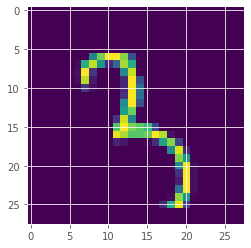

In [45]:
idx = 195
plt.imshow(x_test[idx][:,:,0])

In [46]:
def average(nums):
    return sum(nums) / len(nums)

def argmax(lst):
    return lst.index(max(lst))

print(f"Ground truth is {y_test[idx].argmax()}")

my_predictions = []
for m in models:
    my_predictions.append(np.squeeze(m.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1)))

final_predictions = []
for i in range(len(my_predictions[0])):
    predictions_i = [p[i] for p in my_predictions]
    final_predictions.append(average(predictions_i))
print(f"Ensemble Prediction = {argmax(final_predictions)}")
print(f"Average ensemble predictions = {final_predictions}")

Ground truth is 3
Ensemble Prediction = 8
Average ensemble predictions = [0.0014834945090115071, 0.053206104785203934, 0.16325858384370803, 0.2395269066095352, 0.05325069651007652, 0.10035540610551834, 0.014455706439912319, 0.019183947704732418, 0.3242728114128113, 0.031006322428584098]


In [47]:
my_mc_predictions = []
for m in models:
    my_mc_predictions.append(np.squeeze(mc_model.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1)))

final_mc_predictions = []
for i in range(len(my_mc_predictions[0])):
    predictions_i = [p[i] for p in my_mc_predictions]
    final_mc_predictions.append(average(predictions_i)) 
print(f"MC Prediction = {argmax(final_mc_predictions)}")
print(f"Average MC predictions = {final_mc_predictions}")

MC Prediction = 8
Average MC predictions = [0.005777648673392833, 0.060135442018508914, 0.17206308692693711, 0.23078564256429673, 0.07638834379613399, 0.1323995918035507, 0.020598776824772357, 0.01346166655421257, 0.2508012741804123, 0.03758852761238814]


In [59]:
my_mc_predictions2 = []
for m in models:
    my_mc_predictions2.append(np.squeeze(mc_model2.predict(np.expand_dims(x_test[idx], axis=0), batch_size=1)))

final_mc_predictions2 = []
for i in range(len(my_mc_predictions2[0])):
    predictions_i = [p[i] for p in my_mc_predictions2]
    final_mc_predictions2.append(average(predictions_i)) 
print(f"MC Prediction = {argmax(final_mc_predictions2)}")
print(f"Average MC predictions = {final_mc_predictions2}")

MC Prediction = 2
Average MC predictions = [0.0029442126397043467, 9.554332058314685e-06, 0.9775832533836365, 0.000979401982476702, 0.0011873565264977515, 0.00022655678294540847, 0.01044643521308899, 0.00044075006844650487, 0.005775883281603456, 0.0004066247354785446]


"In deep learning, practitioners set dropout rates between 20% and 50% range, meaning that up to half of the connections of a certain layer will be set to zero during inference."

## High level plan for aleatoric uncertainty model

In [48]:
# def get_model(mc=False, act="relu"):
#     inp = Input(input_shape)
#     x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
#     x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = get_dropout(x, p=0.25, mc=mc)
#     x = Flatten()(x)
#     x = Dense(128, activation=act)(x)
#     x = get_dropout(x, p=0.5, mc=mc)
#     out = Dense(num_classes, activation='softmax')(x)
#     # out2 = Dense(num_classes, activation='softplus')(x)  Or relu
#     # For classificiation, can either be 1 or num_classes for aleatoric uncertainty
#     # Probably num_classes, then for each prediction, looking at the sigma of the prediction
#     model = Model(inputs=inp, outputs=[out, out2])

#     model.compile(loss=keras.losses.categorical_crossentropy, # Replace with custom loss
#                   optimizer=keras.optimizers.Adadelta(),
#                   metrics=['accuracy'])
#     return model